# Data Exploration

This notebook explores the TLC trip record data using PySpark to understand data structure, quality, and coverage for our service consistency analysis.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TLC_Data_Exploration") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Set plotting style for visualizations
plt.style.use('default')
sns.set_palette("husl")

print(f"Spark version: {spark.version}")
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/12 19:07:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.0.0
Spark UI available at: http://10.0.9.9:4040


## 1. Loading Complete 2024 Training Dataset

Loading and combining all 6 months of data (Jan-June 2024) for comprehensive analysis.

In [2]:
# Define our training period
months_2024 = ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06']

# Load and union all yellow taxi data
print("=== LOADING YELLOW TAXI DATA (JAN-JUNE 2024) ===")
yellow_dataframes = []

for month in months_2024:
    try:
        df = spark.read.parquet(f'../data/raw/taxi_2024/yellow_tripdata_{month}.parquet')
        # Add month column for tracking
        df = df.withColumn("data_month", lit(month))
        yellow_dataframes.append(df)
        print(f"Loaded {month}: {df.count():,} records")
    except Exception as e:
        print(f"Error loading {month}: {str(e)}")

# Union all yellow taxi data
yellow_full = yellow_dataframes[0]
for df in yellow_dataframes[1:]:
    yellow_full = yellow_full.union(df)

print(f"Total Yellow Taxi Records: {yellow_full.count():,}")

# Load and union all green taxi data  
print("\n=== LOADING GREEN TAXI DATA (JAN-JUNE 2024) ===")
green_dataframes = []

for month in months_2024:
    try:
        df = spark.read.parquet(f'../data/raw/taxi_2024/green_tripdata_{month}.parquet')
        df = df.withColumn("data_month", lit(month))
        green_dataframes.append(df)
        print(f"Loaded {month}: {df.count():,} records")
    except Exception as e:
        print(f"Error loading {month}: {str(e)}")

# Union all green taxi data
green_full = green_dataframes[0]
for df in green_dataframes[1:]:
    green_full = green_full.union(df)

print(f"Total Green Taxi Records: {green_full.count():,}")

=== LOADING YELLOW TAXI DATA (JAN-JUNE 2024) ===
Loaded 2024-01: 2,964,624 records
Loaded 2024-02: 3,007,526 records
Loaded 2024-03: 3,582,628 records
Loaded 2024-04: 3,514,289 records
Loaded 2024-05: 3,723,833 records
Loaded 2024-06: 3,539,193 records
Total Yellow Taxi Records: 20,332,093

=== LOADING GREEN TAXI DATA (JAN-JUNE 2024) ===
Loaded 2024-01: 56,551 records
Loaded 2024-02: 53,577 records
Loaded 2024-03: 57,457 records
Loaded 2024-04: 56,471 records
Loaded 2024-05: 61,003 records
Loaded 2024-06: 54,748 records
Total Green Taxi Records: 339,807


In [3]:
# Examine schemas to ensure consistency
print("=== YELLOW TAXI SCHEMA ===")
yellow_full.printSchema()

print("\n=== GREEN TAXI SCHEMA ===")
green_full.printSchema()

print("\n=== SCHEMA COMPARISON ===")
yellow_cols = set(yellow_full.columns)
green_cols = set(green_full.columns)

common_cols = yellow_cols & green_cols
yellow_only = yellow_cols - green_cols
green_only = green_cols - yellow_cols

print(f"Common columns: {len(common_cols)}")
print(f"Yellow-only columns: {yellow_only}")
print(f"Green-only columns: {green_only}")

# Show sample records
print("\n=== SAMPLE RECORDS ===")
print("Yellow taxi sample:")
yellow_full.show(2, truncate=False)
print("Green taxi sample:")
green_full.show(2, truncate=False)

=== YELLOW TAXI SCHEMA ===
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- data_month: string (nullable = false)


=== GREEN TAXI SCHEMA ===
root
 |-- VendorID: integer 

## Complete Timeline Coverage Analysis

Validating data completeness across our full 6-month training period.

In [4]:
# Monthly coverage analysis
print("=== MONTHLY COVERAGE ANALYSIS ===")

yellow_monthly = yellow_full.groupBy("data_month").count().orderBy("data_month")
green_monthly = green_full.groupBy("data_month").count().orderBy("data_month")

print("Yellow taxi monthly breakdown:")
yellow_monthly.show()

print("Green taxi monthly breakdown:")
green_monthly.show()

# Daily coverage check
print("\n=== DAILY COVERAGE VALIDATION ===")

# Check for missing days
yellow_daily_coverage = yellow_full.select(
    date_format("tpep_pickup_datetime", "yyyy-MM-dd").alias("trip_date")
).distinct().count()

green_daily_coverage = green_full.select(
    date_format("lpep_pickup_datetime", "yyyy-MM-dd").alias("trip_date")
).distinct().count()

print(f"Yellow taxi covers {yellow_daily_coverage} distinct days")
print(f"Green taxi covers {green_daily_coverage} distinct days")
print(f"Expected days (Jan-June 2024): ~181-182 days")

# Date range validation
yellow_date_range = yellow_full.select(
    min("tpep_pickup_datetime").alias("min_date"),
    max("tpep_pickup_datetime").alias("max_date")
).collect()[0]

green_date_range = green_full.select(
    min("lpep_pickup_datetime").alias("min_date"),
    max("lpep_pickup_datetime").alias("max_date")
).collect()[0]

print(f"Yellow date range: {yellow_date_range['min_date']} to {yellow_date_range['max_date']}")
print(f"Green date range: {green_date_range['min_date']} to {green_date_range['max_date']}")

=== MONTHLY COVERAGE ANALYSIS ===
Yellow taxi monthly breakdown:


+----------+-------+
|data_month|  count|
+----------+-------+
|   2024-01|2964624|
|   2024-02|3007526|
|   2024-03|3582628|
|   2024-04|3514289|
|   2024-05|3723833|
|   2024-06|3539193|
+----------+-------+

Green taxi monthly breakdown:
+----------+-----+
|data_month|count|
+----------+-----+
|   2024-01|56551|
|   2024-02|53577|
|   2024-03|57457|
|   2024-04|56471|
|   2024-05|61003|
|   2024-06|54748|
+----------+-----+


=== DAILY COVERAGE VALIDATION ===


Yellow taxi covers 188 distinct days
Green taxi covers 185 distinct days
Expected days (Jan-June 2024): ~181-182 days


Yellow date range: 2002-12-31 16:46:07 to 2026-06-26 23:53:12
Green date range: 2008-12-31 23:02:24 to 2024-06-30 23:57:10


In [5]:
yellow_full.describe().show()
green_full.describe().show()

25/08/12 19:15:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+-----------------+------------------+---------------------+-----------------+--------------------+-------------------+----------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|      fare_amount|             extra|            mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|     total_amount|congestion_surcharge|        Airport_fee|data_month|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------------------+-----------------+------------------+---------------------+-----------------+------------

+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------+---------------------+------------------+------------------+-------------------+--------------------+----------+
|summary|           VendorID|store_and_fwd_flag|        RatecodeID|      PULocationID|     DOLocationID|   passenger_count|     trip_distance|       fare_amount|             extra|           mta_tax|        tip_amount|       tolls_amount|ehail_fee|improvement_surcharge|      total_amount|      payment_type|          trip_type|congestion_surcharge|data_month|
+-------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------+---------------------+--------

## Comprehensive Zone Coverage Analysis

Analyzing pickup/dropoff zone patterns across the complete dataset.

In [8]:
# Complete zone coverage analysis
print("=== COMPLETE ZONE COVERAGE ANALYSIS ===")

# Yellow taxi zone statistics
yellow_zone_stats = yellow_full.select(
    count_distinct("PULocationID").alias("unique_pickup_zones"),
    count_distinct("DOLocationID").alias("unique_dropoff_zones")
).collect()[0]

print(f"Yellow taxi - Unique pickup zones: {yellow_zone_stats['unique_pickup_zones']}")
print(f"Yellow taxi - Unique dropoff zones: {yellow_zone_stats['unique_dropoff_zones']}")

# Green taxi zone statistics  
green_zone_stats = green_full.select(
    count_distinct("PULocationID").alias("unique_pickup_zones"),
    count_distinct("DOLocationID").alias("unique_dropoff_zones")
).collect()[0]

print(f"Green taxi - Unique pickup zones: {green_zone_stats['unique_pickup_zones']}")
print(f"Green taxi - Unique dropoff zones: {green_zone_stats['unique_dropoff_zones']}")

# Zone overlap analysis
yellow_zones = [row[0] for row in yellow_full.select("PULocationID").distinct().collect()]
green_zones = [row[0] for row in green_full.select("PULocationID").distinct().collect()]
common_zones = set(yellow_zones) & set(green_zones)

print(f"Zones served by both taxi types: {len(common_zones)}")
print(f"Yellow-only zones: {len(set(yellow_zones) - set(green_zones))}")
print(f"Green-only zones: {len(set(green_zones) - set(yellow_zones))}")

# Get comprehensive zone activity data
yellow_zone_activity = yellow_full.groupBy("PULocationID").count().orderBy(desc("count"))
green_zone_activity = green_full.groupBy("PULocationID").count().orderBy(desc("count"))

# Zone activity statistics
yellow_activity_stats = yellow_zone_activity.select(
    mean("count").alias("mean_trips"),
    expr("percentile_approx(count, 0.5)").alias("median_trips"),
    expr("percentile_approx(count, 0.95)").alias("p95_trips"),
    expr("percentile_approx(count, 0.05)").alias("p5_trips")
).collect()[0]

print(f"\nYellow taxi zone activity (6 months):")
print(f"  Mean trips per zone: {yellow_activity_stats['mean_trips']:.0f}")
print(f"  Median trips per zone: {yellow_activity_stats['median_trips']:.0f}")
print(f"  95th percentile: {yellow_activity_stats['p95_trips']:.0f}")
print(f"  5th percentile: {yellow_activity_stats['p5_trips']:.0f}")

=== COMPLETE ZONE COVERAGE ANALYSIS ===


Yellow taxi - Unique pickup zones: 262
Yellow taxi - Unique dropoff zones: 261
Green taxi - Unique pickup zones: 249
Green taxi - Unique dropoff zones: 258


Zones served by both taxi types: 249
Yellow-only zones: 13
Green-only zones: 0

Yellow taxi zone activity (6 months):
  Mean trips per zone: 77603
  Median trips per zone: 2255
  95th percentile: 541457
  5th percentile: 25


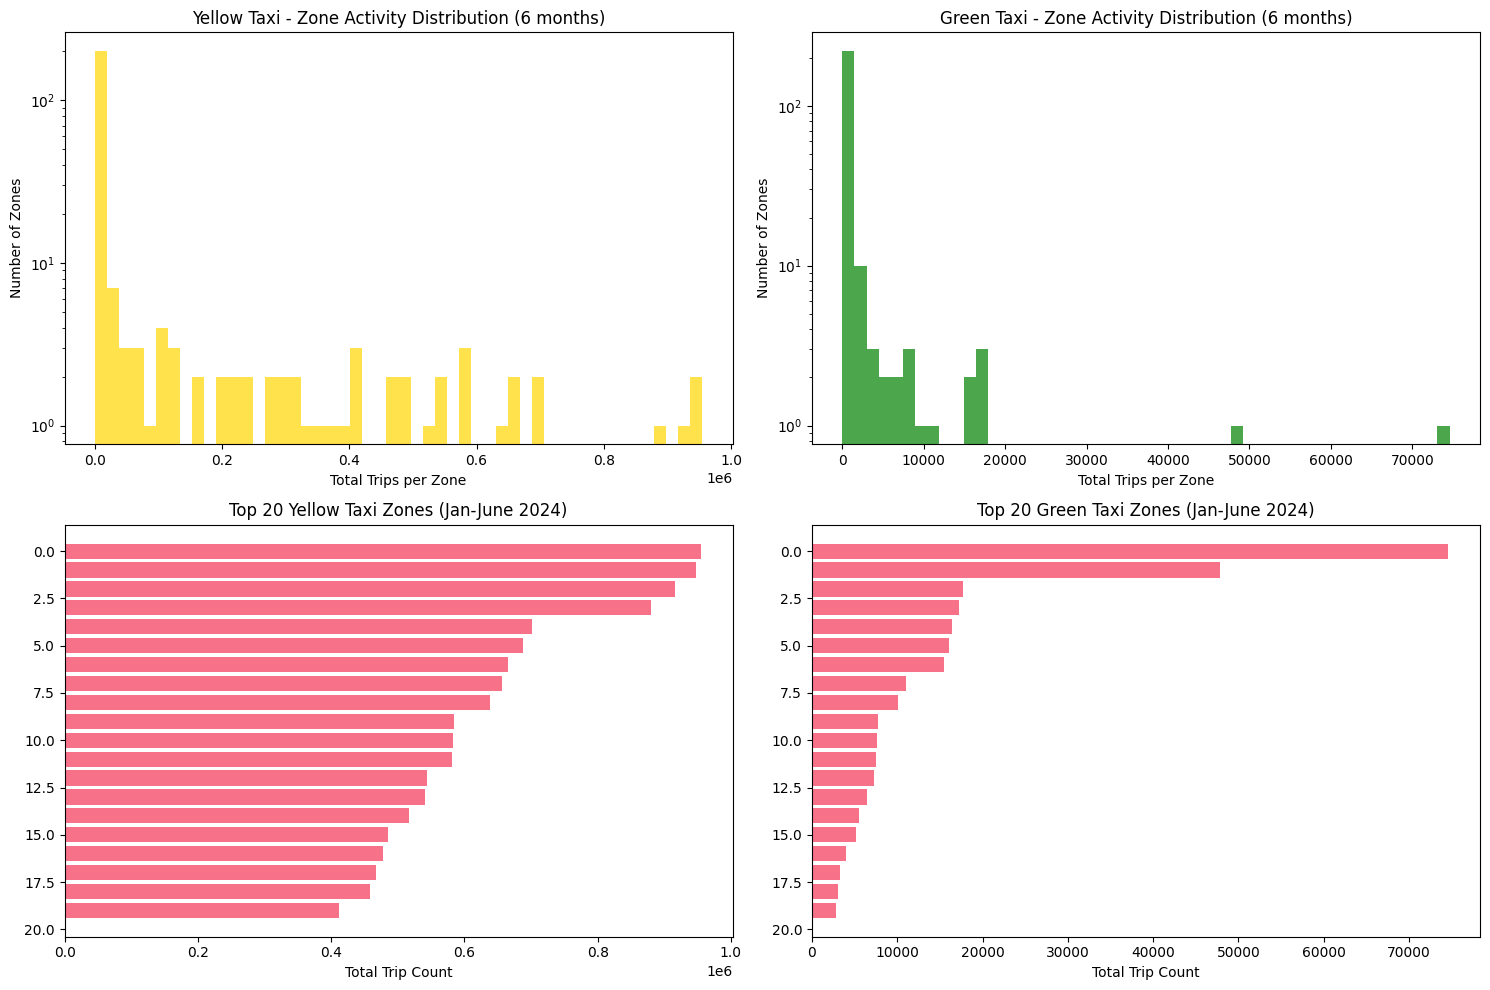

Most active yellow zone: 161 (954,881 trips)
Most active green zone: 74 (74,589 trips)


In [9]:
# Visualize zone activity patterns
# Sample data for visualization
yellow_activity_sample = yellow_zone_activity.toPandas()
green_activity_sample = green_zone_activity.toPandas()
yellow_top20 = yellow_activity_sample.head(20)
green_top20 = green_activity_sample.head(20)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Zone activity distributions
axes[0,0].hist(yellow_activity_sample['count'], bins=50, alpha=0.7, color='gold')
axes[0,0].set_title('Yellow Taxi - Zone Activity Distribution (6 months)')
axes[0,0].set_xlabel('Total Trips per Zone')
axes[0,0].set_ylabel('Number of Zones')
axes[0,0].set_yscale('log')

axes[0,1].hist(green_activity_sample['count'], bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Green Taxi - Zone Activity Distribution (6 months)')
axes[0,1].set_xlabel('Total Trips per Zone')
axes[0,1].set_ylabel('Number of Zones')
axes[0,1].set_yscale('log')

# Top zones
axes[1,0].barh(range(len(yellow_top20)), yellow_top20['count'])
axes[1,0].set_title('Top 20 Yellow Taxi Zones (Jan-June 2024)')
axes[1,0].set_xlabel('Total Trip Count')
axes[1,0].invert_yaxis()

axes[1,1].barh(range(len(green_top20)), green_top20['count'])
axes[1,1].set_title('Top 20 Green Taxi Zones (Jan-June 2024)')
axes[1,1].set_xlabel('Total Trip Count')
axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Most active yellow zone: {yellow_top20.iloc[0]['PULocationID']} ({yellow_top20.iloc[0]['count']:,} trips)")
print(f"Most active green zone: {green_top20.iloc[0]['PULocationID']} ({green_top20.iloc[0]['count']:,} trips)")

## Data Quality Assessment Across Complete Dataset

Comprehensive data quality analysis across all 6 months of training data.

In [10]:
# Missing values analysis across complete dataset
print("=== COMPREHENSIVE DATA QUALITY ASSESSMENT ===")

# Yellow taxi data quality
yellow_total = yellow_full.count()
yellow_quality = {}

for col_name in yellow_full.columns:
    missing_count = yellow_full.filter(col(col_name).isNull()).count()
    if missing_count > 0:
        yellow_quality[col_name] = {
            'missing_count': missing_count,
            'missing_pct': (missing_count / yellow_total) * 100
        }

print("Yellow taxi missing values:")
for col_name, stats in yellow_quality.items():
    print(f"  {col_name}: {stats['missing_count']:,} ({stats['missing_pct']:.2f}%)")

# Green taxi data quality
green_total = green_full.count()
green_quality = {}

for col_name in green_full.columns:
    missing_count = green_full.filter(col(col_name).isNull()).count()
    if missing_count > 0:
        green_quality[col_name] = {
            'missing_count': missing_count,
            'missing_pct': (missing_count / green_total) * 100
        }

print("\nGreen taxi missing values:")
for col_name, stats in green_quality.items():
    print(f"  {col_name}: {stats['missing_count']:,} ({stats['missing_pct']:.2f}%)")

=== COMPREHENSIVE DATA QUALITY ASSESSMENT ===


Yellow taxi missing values:
  passenger_count: 1,975,985 (9.72%)
  RatecodeID: 1,975,985 (9.72%)
  store_and_fwd_flag: 1,975,985 (9.72%)
  congestion_surcharge: 1,975,985 (9.72%)
  Airport_fee: 1,975,985 (9.72%)

Green taxi missing values:
  store_and_fwd_flag: 14,219 (4.18%)
  RatecodeID: 14,219 (4.18%)
  passenger_count: 14,219 (4.18%)
  ehail_fee: 339,807 (100.00%)
  payment_type: 14,219 (4.18%)
  trip_type: 14,268 (4.20%)
  congestion_surcharge: 14,219 (4.18%)


In [ ]:
# Zone ID validation across complete dataset
print("=== ZONE ID VALIDATION (COMPLETE DATASET) ===")

# Invalid zones (outside 1-263 range since 264 and 265 are N/A or Unknown)
yellow_invalid_pu = yellow_full.filter((col("PULocationID") < 1) | (col("PULocationID") > 263)).count()
yellow_invalid_do = yellow_full.filter((col("DOLocationID") < 1) | (col("DOLocationID") > 263)).count()
green_invalid_pu = green_full.filter((col("PULocationID") < 1) | (col("PULocationID") > 263)).count()
green_invalid_do = green_full.filter((col("DOLocationID") < 1) | (col("DOLocationID") > 263)).count()

print(f"Invalid yellow pickup zones: {yellow_invalid_pu:,} ({yellow_invalid_pu/yellow_total*100:.3f}%)")
print(f"Invalid yellow dropoff zones: {yellow_invalid_do:,} ({yellow_invalid_do/yellow_total*100:.3f}%)")
print(f"Invalid green pickup zones: {green_invalid_pu:,} ({green_invalid_pu/green_total*100:.3f}%)")
print(f"Invalid green dropoff zones: {green_invalid_do:,} ({green_invalid_do/green_total*100:.3f}%)")

# Calculate data loss from filtering invalid zones
yellow_valid_trips = yellow_full.filter(
    (col("PULocationID") >= 1) & (col("PULocationID") <= 263) &
    (col("DOLocationID") >= 1) & (col("DOLocationID") <= 263) &
    col("PULocationID").isNotNull() & col("DOLocationID").isNotNull()
).count()

green_valid_trips = green_full.filter(
    (col("PULocationID") >= 1) & (col("PULocationID") <= 263) &
    (col("DOLocationID") >= 1) & (col("DOLocationID") <= 263) &
    col("PULocationID").isNotNull() & col("DOLocationID").isNotNull()
).count()

print(f"\nValid yellow trips after zone filtering: {yellow_valid_trips:,} ({yellow_valid_trips/yellow_total*100:.2f}%)")
print(f"Valid green trips after zone filtering: {green_valid_trips:,} ({green_valid_trips/green_total*100:.2f}%)")

=== ZONE ID VALIDATION (COMPLETE DATASET) ===


Invalid yellow pickup zones: 76,985 (0.379%)
Invalid yellow dropoff zones: 182,163 (0.896%)
Invalid green pickup zones: 925 (0.272%)
Invalid green dropoff zones: 3,854 (1.134%)



Valid yellow trips after zone filtering: 20,123,221 (98.97%)
Valid green trips after zone filtering: 335,779 (98.81%)


## 6. Trip Characteristics Analysis

Analyzing trip patterns across the complete 6-month dataset.

In [12]:
# Trip distance and duration analysis on complete dataset
print("=== TRIP CHARACTERISTICS (COMPLETE DATASET) ===")

# Yellow taxi comprehensive trip stats
yellow_trip_stats = yellow_full.select(
    mean("trip_distance").alias("mean_distance"),
    expr("percentile_approx(trip_distance, 0.5)").alias("median_distance"),
    expr("percentile_approx(trip_distance, 0.95)").alias("p95_distance"),
    expr("percentile_approx(trip_distance, 0.99)").alias("p99_distance"),
    sum((col("trip_distance") == 0).cast("int")).alias("zero_distance"),
    sum((col("trip_distance") > 100).cast("int")).alias("extreme_distance"),
    sum((col("trip_distance") < 0).cast("int")).alias("negative_distance")
).collect()[0]

print("Yellow taxi trip distance (6 months):")
print(f"  Mean: {yellow_trip_stats['mean_distance']:.2f} miles")
print(f"  Median: {yellow_trip_stats['median_distance']:.2f} miles")
print(f"  95th percentile: {yellow_trip_stats['p95_distance']:.2f} miles")
print(f"  99th percentile: {yellow_trip_stats['p99_distance']:.2f} miles")
print(f"  Zero distance: {yellow_trip_stats['zero_distance']:,} trips")
print(f"  >100 miles: {yellow_trip_stats['extreme_distance']:,} trips")
print(f"  Negative distance: {yellow_trip_stats['negative_distance']:,} trips")

# Duration analysis
yellow_with_duration = yellow_full.withColumn(
    "duration_minutes",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

duration_stats = yellow_with_duration.select(
    mean("duration_minutes").alias("mean_duration"),
    expr("percentile_approx(duration_minutes, 0.5)").alias("median_duration"),
    expr("percentile_approx(duration_minutes, 0.95)").alias("p95_duration"),
    sum((col("duration_minutes") > 480).cast("int")).alias("very_long_trips"),
    sum((col("duration_minutes") < 0).cast("int")).alias("negative_duration"),
    sum((col("duration_minutes") < 1).cast("int")).alias("very_short_trips")
).collect()[0]

print(f"\nYellow taxi trip duration (6 months):")
print(f"  Mean: {duration_stats['mean_duration']:.1f} minutes")
print(f"  Median: {duration_stats['median_duration']:.1f} minutes") 
print(f"  95th percentile: {duration_stats['p95_duration']:.1f} minutes")
print(f"  >8 hours: {duration_stats['very_long_trips']:,} trips")
print(f"  <1 minute: {duration_stats['very_short_trips']:,} trips")
print(f"  Negative duration: {duration_stats['negative_duration']:,} trips")

=== TRIP CHARACTERISTICS (COMPLETE DATASET) ===


Yellow taxi trip distance (6 months):
  Mean: 4.70 miles
  Median: 1.75 miles
  95th percentile: 13.42 miles
  99th percentile: 19.87 miles
  Zero distance: 364,322 trips
  >100 miles: 725 trips
  Negative distance: 0 trips



Yellow taxi trip duration (6 months):
  Mean: 16.9 minutes
  Median: 12.6 minutes
  95th percentile: 42.1 minutes
  >8 hours: 10,945 trips
  <1 minute: 235,582 trips
  Negative duration: 300 trips


## Temporal Patterns Analysis

Understanding temporal variations across the complete training period.

=== TEMPORAL PATTERNS ANALYSIS ===


Monthly trip distribution:
  data_month  yellow_trips  green_trips  total_trips
0    2024-01       2964624        56551      3021175
1    2024-02       3007526        53577      3061103
2    2024-03       3582628        57457      3640085
3    2024-04       3514289        56471      3570760
4    2024-05       3723833        61003      3784836
5    2024-06       3539193        54748      3593941


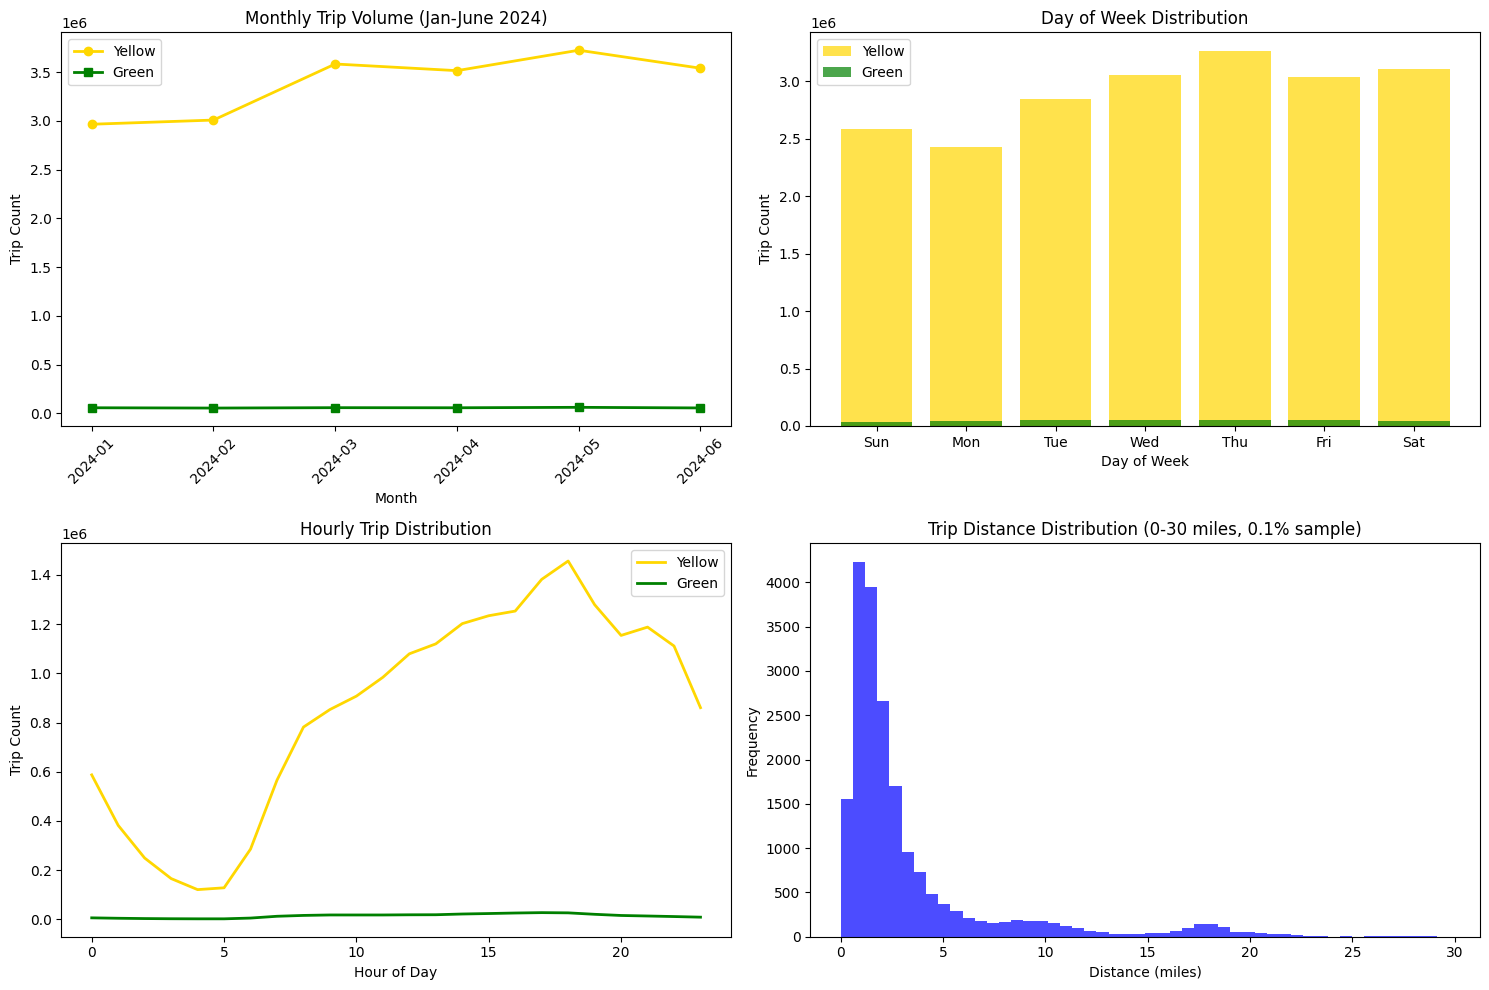

Peak day: Thu (Yellow)
Peak hour: 18:00 (Yellow)


In [13]:
# Monthly trend analysis
print("=== TEMPORAL PATTERNS ANALYSIS ===")

# Monthly totals and trends
monthly_comparison = yellow_monthly.join(green_monthly, "data_month", "outer") \
    .select(
        col("data_month"),
        coalesce(yellow_monthly["count"], lit(0)).alias("yellow_trips"),
        coalesce(green_monthly["count"], lit(0)).alias("green_trips")
    ).withColumn(
        "total_trips", col("yellow_trips") + col("green_trips")
    ).orderBy("data_month")

monthly_data = monthly_comparison.toPandas()
print("Monthly trip distribution:")
print(monthly_data)

# Day of week patterns
yellow_dow = yellow_full.select(
    dayofweek("tpep_pickup_datetime").alias("day_of_week")
).groupBy("day_of_week").count().orderBy("day_of_week").toPandas()

green_dow = green_full.select(
    dayofweek("lpep_pickup_datetime").alias("day_of_week")
).groupBy("day_of_week").count().orderBy("day_of_week").toPandas()

# Hour of day patterns
yellow_hour = yellow_full.select(
    hour("tpep_pickup_datetime").alias("hour")
).groupBy("hour").count().orderBy("hour").toPandas()

green_hour = green_full.select(
    hour("lpep_pickup_datetime").alias("hour")
).groupBy("hour").count().orderBy("hour").toPandas()

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly trends
axes[0,0].plot(monthly_data['data_month'], monthly_data['yellow_trips'], 
               label='Yellow', color='gold', linewidth=2, marker='o')
axes[0,0].plot(monthly_data['data_month'], monthly_data['green_trips'], 
               label='Green', color='green', linewidth=2, marker='s')
axes[0,0].set_title('Monthly Trip Volume (Jan-June 2024)')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Trip Count')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Day of week patterns
day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
axes[0,1].bar(range(len(yellow_dow)), yellow_dow['count'], alpha=0.7, label='Yellow', color='gold')
axes[0,1].bar(range(len(green_dow)), green_dow['count'], alpha=0.7, label='Green', color='green')
axes[0,1].set_title('Day of Week Distribution')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Trip Count')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_labels)
axes[0,1].legend()

# Hourly patterns
axes[1,0].plot(yellow_hour['hour'], yellow_hour['count'], label='Yellow', color='gold', linewidth=2)
axes[1,0].plot(green_hour['hour'], green_hour['count'], label='Green', color='green', linewidth=2)
axes[1,0].set_title('Hourly Trip Distribution')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Trip Count')
axes[1,0].legend()

# Trip distance distribution (sampled)
distance_sample = yellow_full.select("trip_distance").filter(
    (col("trip_distance") > 0) & (col("trip_distance") <= 30)
).sample(0.001).toPandas()

axes[1,1].hist(distance_sample['trip_distance'], bins=50, alpha=0.7, color='blue')
axes[1,1].set_title('Trip Distance Distribution (0-30 miles, 0.1% sample)')
axes[1,1].set_xlabel('Distance (miles)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Peak day: {day_labels[yellow_dow.loc[yellow_dow['count'].idxmax(), 'day_of_week']-1]} (Yellow)")
print(f"Peak hour: {yellow_hour.loc[yellow_hour['count'].idxmax(), 'hour']}:00 (Yellow)")

In [ ]:
# Save the complete datasets for use in subsequent notebooks
print("=== SAVING DATASETS FOR NEXT NOTEBOOKS ===")

yellow_full.write.mode("overwrite").parquet("../data/interim/yellow_2024_complete.parquet")
green_full.write.mode("overwrite").parquet("../data/interim/green_2024_complete.parquet")

print(f"Saved yellow_2024_complete.parquet: {yellow_total:,} records")
print(f"Saved green_2024_complete.parquet: {green_total:,} records")

# Stop Spark session
spark.stop()

=== SAVING DATASETS FOR NEXT NOTEBOOKS ===


25/08/12 20:59:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/08/12 20:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/08/12 20:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/08/12 20:59:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/08/12 20:59:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/08/12 20:59:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/08/12 20:59:43 WARN MemoryManager: Total allocation exceeds 95.00% 

Saved yellow_2024_complete.parquet: 20,332,093 records
Saved green_2024_complete.parquet: 339,807 records
Exploration complete.
